In [4]:
from utils.load_results import *
from utils.plot_helpers import *
from utils.analysis_from_interaction import effective_vocab_size
import torch
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
plt.style.use('default')

# Quantitative analyses
This notebook contains code to plot and bootstrap confidence intervals for accuracies and other metrics for both context-unaware and context-aware trained agents.
Code defaults to context-aware, context-unaware results can be loaded by setting the context-unaware flag.

In [9]:
datasets = ['(3,4)', '(3,8)', '(3,16)', '(4,4)', '(4,8)', '(5,4)']
n_values = [4, 8, 16, 4, 8, 4]
n_attributes = [3, 3, 3, 4, 4, 5]
vocab_sizes = [5, 9, 17, 5, 9, 5]
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_0' for d in datasets]

In [427]:
datasets = ['(3,4)', '(3,8)', '(4,4)']
n_values = [4, 8, 4]
n_attributes = [3, 3, 4]
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_0' for d in datasets]

In [23]:
context_unaware = False # whether original or context_unaware simulations are evaluated
length_cost = True # whether length_cost was applied
early_stopping = True
sampled_context = False # actually true, but this would navigate to a different folder
test_interactions = True # whether scores should be calculated on test interactions
test_mode = 'test'
if context_unaware:
    path_context_setting = "context_unaware"
else:
    if length_cost:
        path_context_setting = "context_aware"
    else:
        path_context_setting = "standard"
if length_cost:
    path_length_cost = "length_cost/"
else:
    path_length_cost = ""
if sampled_context:
    path_sampled_context = "/sampled_context"
else:
    path_sampled_context = ""
setting = path_length_cost + path_context_setting + path_sampled_context

In [24]:
# get n_epochs if early stopping
if early_stopping:
    
    n_epochs_all_data = []
    for d in range(len(datasets)):
        
        epochs = []
        
        for run in range(n_runs):
    
            path_to_run = paths[d] + '/' + setting +'/' + str(run) + '/' 
            with open(os.path.join(path_to_run, 'loss_and_metrics.pkl'), 'rb') as input_file:
                data = pickle.load(input_file)
                final_epoch = max(data['loss_train'].keys())
                epochs.append(final_epoch)
                
        n_epochs_all_data.append(epochs)
        
else:
    n_epochs_all_data = []
    for d in range(len(datasets)):
        epochs = []
        
        for run in range(n_runs):
            epochs.append(n_epochs)
                
        n_epochs_all_data.append(epochs)
            

In [460]:
for d in range(len(datasets)):
    
    n_epochs = []
    
    for run in range(n_runs):

        path_to_run = paths[d] + '/' + setting +'/' + str(run) + '/' 
        with open(os.path.join(path_to_run, 'params.pkl'), 'rb') as input_file:
            data = pickle.load(input_file)
            print(data)

Namespace(load_dataset='dim(3,4)_context_sampled.ds', dimensions=[4, 4, 4], attributes=3, values=4, game_size=10, scaling_factor=10, vocab_size_factor=0, vocab_size_user=5, hidden_size=128, sender_cell='gru', receiver_cell='gru', learning_rate=0.001, temperature=2, length_cost=0.003, temp_update=0.99, save=True, num_of_runs=5, zero_shot=False, zero_shot_test=None, device=device(type='cpu'), path='', include_concept=False, context_unaware=True, max_mess_len=20, mu_and_goodman=False, speaker_hidden_size=128, listener_hidden_size=128, speaker_n_layers=2, listener_n_layers=2, early_stopping=True, patience=10, min_delta=0.001, min_acc_early_stopping=0.9, load_checkpoint=False, load_interaction=False, test_rsa=None, cost_factor=0.01, sample_context=True, random_seed=703435469, checkpoint_dir=None, preemptable=False, checkpoint_freq=0, validation_freq=1, n_epochs=300, load_from_checkpoint=None, no_cuda=True, batch_size=16, optimizer='adam', lr=0.01, update_freq=1, vocab_size=10, max_len=1, te

## Accuracies

### Training trajectories

In [129]:
all_accuracies = load_accuracies(paths, n_runs=n_runs, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=context_unaware, length_cost=length_cost, early_stopping=early_stopping, sampled_context=sampled_context)

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/load_results.py:427: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


### Final accuracies 
Final accuracies heatmap plot + get accuracy means and sds for table representation.

In [130]:
if not context_unaware:
    accuracies = [all_accuracies['train_acc'], all_accuracies['val_acc']]
    test_accuracies = all_accuracies['test_acc']
else:
    accuracies = [all_accuracies['cu_train_acc'], all_accuracies['cu_val_acc']]
    test_accuracies = all_accuracies['cu_test_acc']

In [131]:
# training
final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(n_runs):
        if not context_unaware:
            gather_accuracies.append(all_accuracies['train_acc'][i][run][-1])
        else:
            gather_accuracies.append(all_accuracies['cu_train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
df_train = pd.DataFrame(final_accuracies_train).transpose().rename(columns={0: 'mean', 1: 'sd'})
df_train['train'] = df_train.apply(lambda row: f'{row["mean"]:.2f} ± {row["sd"]:.2f}', axis=1)

In [132]:
# validation
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(n_runs):
        if not context_unaware:
            gather_accuracies.append(all_accuracies['val_acc'][i][run][-1])
        else:
            gather_accuracies.append((all_accuracies['cu_val_acc'][i][run][-1]))
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
df_val = pd.DataFrame(final_accuracies_val).transpose().rename(columns={0: 'mean', 1: 'sd'})
df_val['validation'] = df_val.apply(lambda row: f'{row["mean"]:.2f} ± {row["sd"]:.2f}', axis=1)

In [133]:
test_accuracies

array([[0.733235  , 0.7474125 , 0.72543508, 0.74106503, 0.73840255],
       [0.90186852, 0.89207405, 0.88589889, 0.90839684, 0.90577269],
       [0.92224258, 0.94138867, 0.8969084 , 0.88899356, 0.93416518],
       [0.88503748, 0.8500675 , 0.9311499 , 0.93019998, 0.92721242],
       [0.91874522, 0.96197361, 0.92395914, 0.92404276, 0.97149962],
       [0.94783151, 0.94861805, 0.93336451, 0.96903658, 0.95342749]])

In [134]:
def calc_mean_std(row):
    mean = np.mean(row)
    std = np.std(row)
    return f'{mean:.2f} ± {std:.2f}'

results = np.apply_along_axis(calc_mean_std, 1, test_accuracies)
df_test = pd.DataFrame(results, columns=['test'])
df_test.index = datasets

In [136]:
df_acc = pd.concat([df_train['train'], df_val['validation'], df_test], axis=1)
latex_table = df_acc.to_latex()
print(latex_table)

\begin{tabular}{llll}
\toprule
{} &        train &   validation &         test \\
\midrule
(3,4)  &  0.97 ± 0.00 &  0.93 ± 0.00 &  0.74 ± 0.01 \\
(3,8)  &  0.97 ± 0.01 &  0.96 ± 0.01 &  0.90 ± 0.01 \\
(3,16) &  0.96 ± 0.01 &  0.94 ± 0.03 &  0.92 ± 0.02 \\
(4,4)  &  0.95 ± 0.04 &  0.93 ± 0.04 &  0.90 ± 0.03 \\
(4,8)  &  0.96 ± 0.02 &  0.94 ± 0.02 &  0.94 ± 0.02 \\
(5,4)  &  0.96 ± 0.01 &  0.95 ± 0.01 &  0.95 ± 0.01 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_81513/4150073812.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_acc.to_latex()


## Lexicon properties

### Effective vocab size

In [25]:
eff_vocab_dict = {'dataset': [], 'run': [], 'effective vocab size': [], 'ratio effective vocab': []}
for i, d in enumerate(datasets):
    for run in range(n_runs):
        path_to_run = paths[i] + '/' + setting +'/' + str(run) + '/'
        if test_interactions:
            path_to_interaction_test = (path_to_run + 'interactions/' + test_mode + '/epoch_0' + '/interaction_gpu0')
            test_interaction = torch.load(path_to_interaction_test)
            eff_vocab_size, _, eff_vocab_ratio = effective_vocab_size(test_interaction, vocab_size=vocab_sizes[i])
        else:
            path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
            train_interaction = torch.load(path_to_interaction_train)
            eff_vocab_size, _, eff_vocab_ratio = effective_vocab_size(train_interaction, vocab_size=vocab_sizes[i])
        
        eff_vocab_dict['dataset'].append(d)
        eff_vocab_dict['run'].append(run)
        eff_vocab_dict['effective vocab size'].append(eff_vocab_size)
        eff_vocab_dict['ratio effective vocab'].append(eff_vocab_ratio)

In [34]:
df = pd.DataFrame(eff_vocab_dict)
df.groupby('dataset').mean()
df.mean().round(2)
# context-aware D(3,8): two runs with 6, 7 symbols instead of 9

/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_12142/637158496.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean().round(2)


run                      2.00
effective vocab size     8.17
ratio effective vocab    0.98
dtype: float64

### Lexicon size and informativeness

In [461]:
distance = 'manhattan' # 'manhattan' or 'euclidean'

In [462]:
lexprop_dict = {'dataset': [], 'run': [], 'lexicon informativeness': [], 'lexicon size': [], 'number of concepts': [], 'lexicon ratio': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        if test_interactions:
            lexprops = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/lexicon_properties_' + distance + '_' + test_mode + '.pkl', 'rb'))
        else:
            lexprops = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/lexicon_properties_' + distance + '.pkl', 'rb'))
            
        lexprop_dict['run'].append(run)
        lexprop_dict['dataset'].append(dataset)
        lexprop_dict['lexicon informativeness'].append(lexprops['lexicon informativeness'])
        lexprop_dict['lexicon size'].append(lexprops['lexicon size'])
        lexprop_dict['number of concepts'].append(lexprops['number of concepts'])
        lexprop_dict['lexicon ratio'].append((lexprops['lexicon size']/lexprops['number of concepts']))
            
df_lexprop = pd.DataFrame(lexprop_dict)

In [463]:
stats_lexprop = df_lexprop.groupby(['dataset'])['number of concepts'].agg(['mean', 'std']).reset_index()
stats_size = df_lexprop.groupby(['dataset'])['lexicon size'].agg(['mean', 'std']).reset_index()
stats_lexprop['number of concepts'] = stats_lexprop['mean'].astype(int)
stats_lexprop['lexicon size'] = stats_size['mean'].round(2).astype(str) + ' ± ' + stats_size['std'].round(2).astype(str)
stats_lexprop = stats_lexprop.drop(['mean', 'std'], axis=1)
print(stats_lexprop.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
dataset &  number of concepts &    lexicon size \\
\midrule
 (3,16) &                9830 &  341.0 ± 127.11 \\
  (3,4) &                 250 &    144.0 ± 9.41 \\
  (3,8) &                1460 &  367.4 ± 108.79 \\
  (4,4) &                1250 &   579.0 ± 51.26 \\
  (4,8) &               13120 & 1773.0 ± 917.58 \\
  (5,4) &                6250 & 2392.2 ± 575.79 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_81513/4121243032.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_lexprop.to_latex(index=False))


In [464]:
stats_lexprop = df_lexprop.groupby(['dataset'])['lexicon informativeness'].agg(['mean', 'std']).reset_index()
stats_ratio = df_lexprop.groupby(['dataset'])['lexicon ratio'].agg(['mean', 'std']).reset_index()
stats_lexprop['lexicon ratio'] = stats_ratio['mean'].round(2).astype(str) + ' ± ' + stats_ratio['std'].round(2).astype(str)
stats_lexprop['lexicon informativeness'] = stats_lexprop['mean'].round(2).astype(str) + ' ± ' + stats_lexprop['std'].round(2).astype(str)
stats_lexprop = stats_lexprop.drop(['mean', 'std'], axis=1)
print(stats_lexprop.to_latex(index=False))

\begin{tabular}{lll}
\toprule
dataset & lexicon ratio & lexicon informativeness \\
\midrule
 (3,16) &   0.03 ± 0.01 &             3.11 ± 0.25 \\
  (3,4) &   0.58 ± 0.04 &             6.21 ± 0.42 \\
  (3,8) &   0.25 ± 0.07 &             5.37 ± 0.43 \\
  (4,4) &   0.46 ± 0.04 &             5.92 ± 0.33 \\
  (4,8) &   0.14 ± 0.07 &              4.2 ± 0.56 \\
  (5,4) &   0.38 ± 0.09 &             5.48 ± 0.31 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_81513/277258687.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_lexprop.to_latex(index=False))


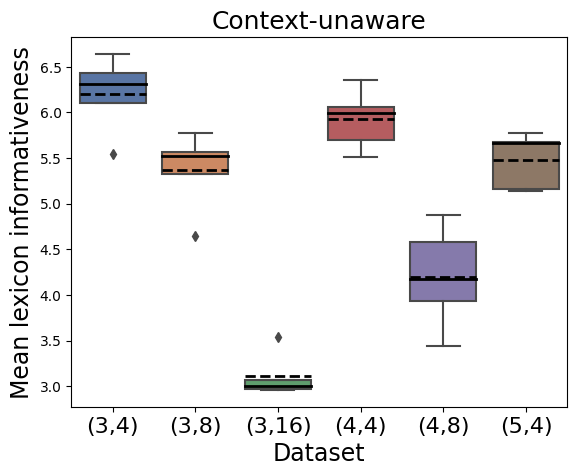

In [465]:
# Create a boxplot for each dataset
sns.boxplot(x='dataset', y='lexicon informativeness', data=df_lexprop, whis=1.5,
            palette='deep', showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
#g.set_titles(col_template="{col_name}", fontsize=50)
#g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
plt.xlabel(xlabel='Dataset', fontsize=17)
plt.ylabel(ylabel='Mean lexicon informativeness', fontsize=17)
plt.xticks(fontsize=16)
#plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=16)
#plt.ylim(0, 21)
if context_unaware:
    plt.title('Context-unaware', fontsize=18)
else:
    plt.title('Context-aware', fontsize=18)
plt.show()

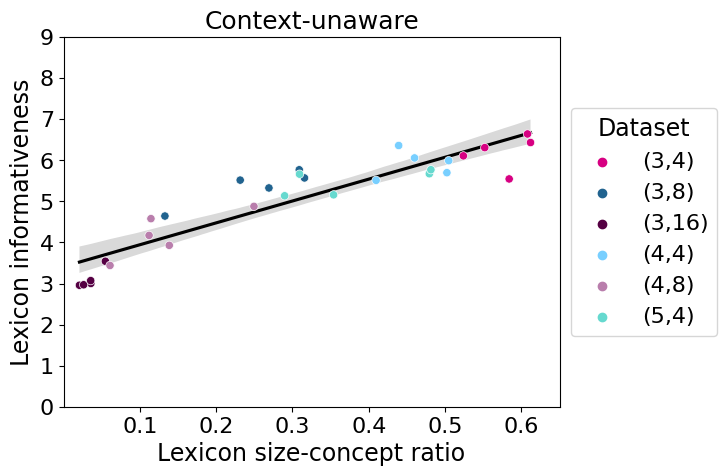

In [355]:
# Create a scatterplot with regression line
scatter = sns.scatterplot(x = 'lexicon ratio', y='lexicon informativeness', data=df_lexprop, hue='dataset', zorder=2,
                              palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]))
reg = sns.regplot(x = 'lexicon ratio', y = 'lexicon informativeness', data=df_lexprop, scatter=False, color="black")
lines = reg.get_lines()
for line in lines:
    line.set_zorder(1)  # Regression line behind
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='Dataset', title_fontsize=17)
plt.xlabel(xlabel='Lexicon size-concept ratio', fontsize=17)
plt.ylabel(ylabel='Lexicon informativeness', fontsize=17)
plt.xticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 9)
plt.xlim(0, 0.65)
if context_unaware:
    plt.title('Context-unaware', fontsize=18)
else:
    plt.title('Context-aware', fontsize=18)
plt.show()

## Message length

### Final message length

In [291]:
# training
final_ml_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(n_runs):
        if not context_unaware:
            gather_accuracies.append(all_accuracies['train_message_lengths'][i][run][-1])
        else:
            gather_accuracies.append(all_accuracies['cu_train_message_lengths'][i][run][-1])
    final_ml_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_ml_train

IndexError: index 0 is out of bounds for axis 0 with size 0

In [292]:
ml_dict = {'dataset': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        if not test_interactions:
            ml = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length.pkl', 'rb'))
        else:
            ml = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_' + test_mode + '.pkl', 'rb'))
            
        ml_dict['run'].append(run)
        ml_dict['dataset'].append(dataset)
        try: 
            ml_dict['message length'].append(np.mean(ml.numpy()))
        except: 
            ml_dict['message length'].append(np.NaN)
df_ml = pd.DataFrame(ml_dict)

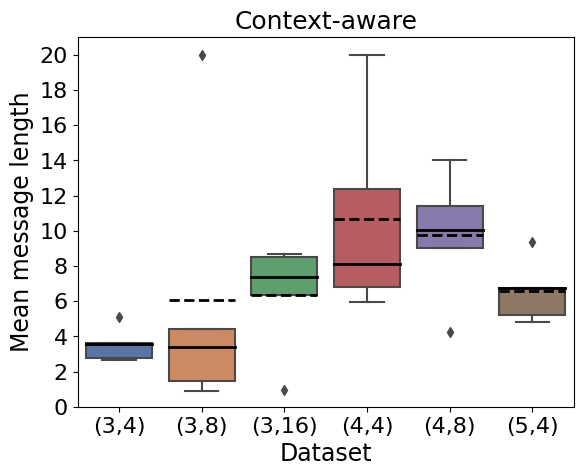

In [293]:
# Create a boxplot for each dataset
sns.boxplot(x='dataset', y='message length', data=df_ml, whis=1.5,
            palette='deep', showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
#g.set_titles(col_template="{col_name}", fontsize=50)
#g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
plt.xlabel(xlabel='Dataset', fontsize=17)
plt.ylabel(ylabel='Mean message length', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=16)
plt.ylim(0, 21)
#legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
#plt.setp(legend.get_title(),fontsize='x-large')
if context_unaware:
    plt.title('Context-unaware', fontsize=18)
else:
    plt.title('Context-aware', fontsize=18)
plt.show()

### Message lengths per concept hierarchy level

In [351]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):

        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        if not test_interactions:
            ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        else:
            ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical_' + test_mode + '.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

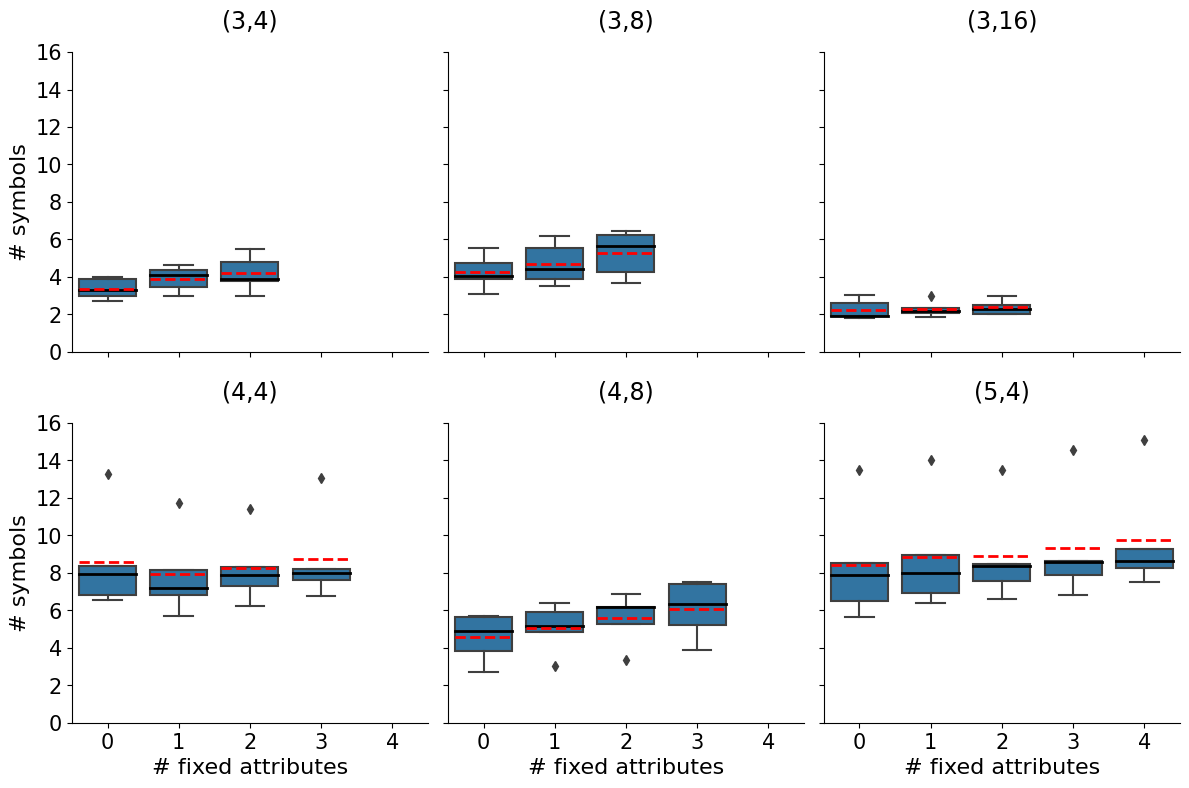

In [344]:
# Create a FacetGrid
g = sns.FacetGrid(pd.DataFrame(ml_dict), col="data set", col_wrap=3, sharey=True, height=4)
# Map the boxplot to each subplot in the grid
g.map(sns.boxplot, "level", "message length", order=range(5), showmeans=True, meanline=True, meanprops=dict(color="red", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
g.set_titles(col_template="{col_name}", fontsize=50)
g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
for ax in g.axes.flatten():
    ax.set_title(ax.get_title(), fontsize=17, y=1.05)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylim(0,16)
    ax.yaxis.set_ticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
g.tight_layout()
plt.show()

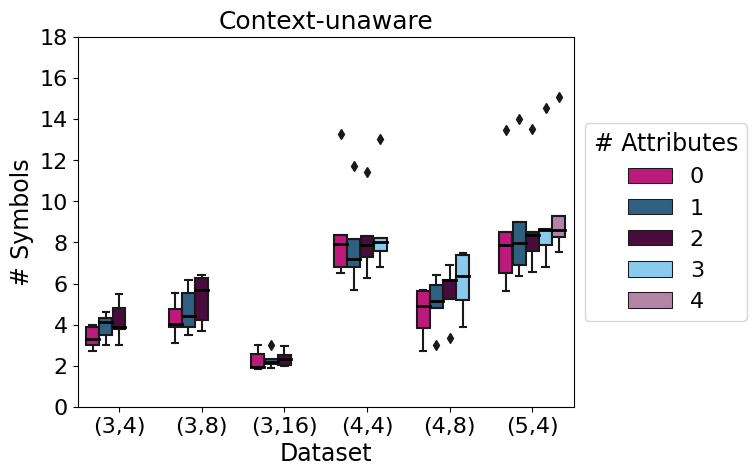

In [352]:
# Create a boxplot for each dataset
sns.boxplot(x='data set', y='message length', data=pd.DataFrame(ml_dict), whis=1.5, hue='level', 
            showmeans=False, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2),
            palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]))
#g.set_titles(col_template="{col_name}", fontsize=50)
#g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='# Attributes', title_fontsize=17)
plt.xlabel(xlabel='Dataset', fontsize=17)
plt.ylabel(ylabel='# Symbols', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=16)
plt.ylim(0, 18)
#legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
#plt.setp(legend.get_title(),fontsize='x-large')
if context_unaware:
    plt.title('Context-unaware', fontsize=18)
else:
    plt.title('Context-aware', fontsize=18)
plt.show()

In [297]:
# latex table representation
df_ml = pd.DataFrame(ml_dict)

stats_ml = df_ml.groupby(['level', 'data set'])['message length'].agg(['mean', 'std']).reset_index()
stats_ml['message length'] = stats_ml['mean'].round(2).astype(str) + ' ± ' + stats_ml['std'].round(2).astype(str)
stats_ml = stats_ml.pivot_table(index='data set', columns='level', values='message length', aggfunc='first')
print(stats_ml.to_latex(index=True))

\begin{tabular}{llllll}
\toprule
level &             0 &             1 &             2 &             3 &            4 \\
data set &               &               &               &               &              \\
\midrule
(3,16)   &   6.51 ± 3.19 &   6.34 ± 3.13 &   6.38 ± 3.18 &     nan ± nan &    nan ± nan \\
(3,4)    &   3.92 ± 1.54 &   3.63 ± 0.89 &   3.39 ± 1.12 &     nan ± nan &    nan ± nan \\
(3,8)    &   5.52 ± 8.11 &   6.01 ± 7.95 &   6.06 ± 7.92 &     nan ± nan &    nan ± nan \\
(4,4)    &  11.64 ± 6.85 &  10.41 ± 5.89 &  10.97 ± 5.69 &  10.45 ± 5.82 &    nan ± nan \\
(4,8)    &   9.67 ± 3.61 &   9.75 ± 3.62 &   9.74 ± 3.55 &   9.75 ± 3.65 &    nan ± nan \\
(5,4)    &    6.9 ± 0.97 &   6.86 ± 1.37 &   6.55 ± 1.64 &   6.59 ± 1.75 &  6.53 ± 1.96 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_81513/1908375173.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_ml.to_latex(index=True))


### Message lengths in fine contexts

In [349]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):

        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        if not test_interactions:
            ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_over_context.pkl', 'rb'))
        else:
            ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_over_context_' + test_mode + '.pkl', 'rb'))
            
        for level in range(n_runs):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical['ml_fine_context'][level])
            except: 
                ml_dict['message length'].append(np.NaN)

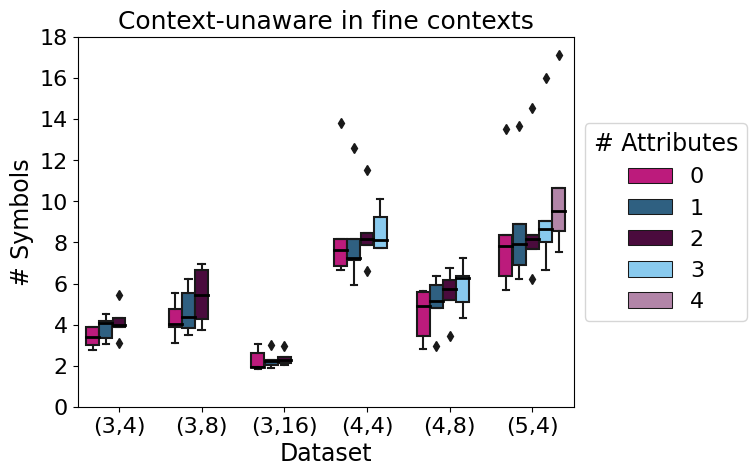

In [350]:
# Create a boxplot for each dataset
sns.boxplot(x='data set', y='message length', data=pd.DataFrame(ml_dict), whis=1.5, hue='level', 
            showmeans=False, meanline=True, meanprops=dict(color="black", linestyle=":", linewidth=2), medianprops=dict(color="black", linewidth=2),
            palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]))
#g.set_titles(col_template="{col_name}", fontsize=50)
#g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='# Attributes', title_fontsize=17)
plt.xlabel(xlabel='Dataset', fontsize=17)
plt.ylabel(ylabel='# Symbols', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=16)
plt.ylim(0, 18)
#legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
#plt.setp(legend.get_title(),fontsize='x-large')
if context_unaware:
    plt.title('Context-unaware in fine contexts', fontsize=18)
else:
    plt.title('Context-aware in fine contexts', fontsize=18)
plt.show()

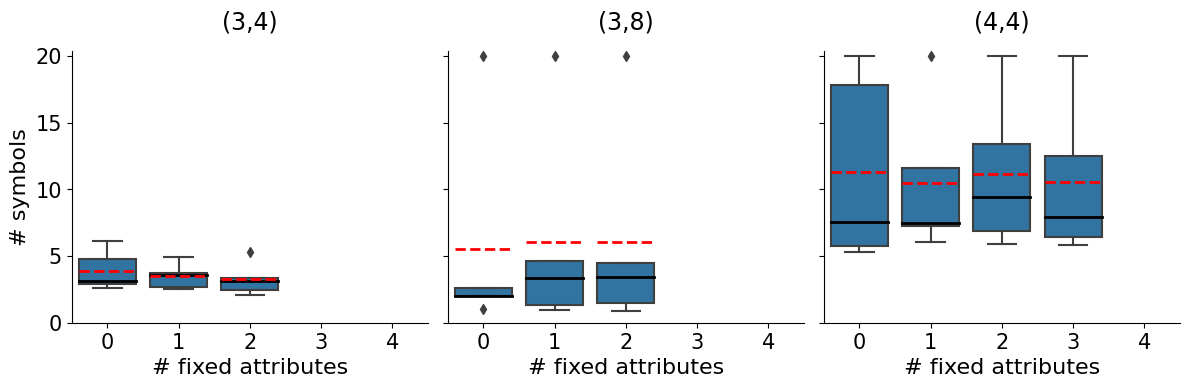

In [86]:
# Create a FacetGrid
g = sns.FacetGrid(pd.DataFrame(ml_dict), col="data set", col_wrap=3, sharey=True, height=4)
# Map the boxplot to each subplot in the grid
g.map(sns.boxplot, "level", "message length", order=range(5), showmeans=True, meanline=True, meanprops=dict(color="red", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
g.set_titles(col_template="{col_name}", fontsize=50)
g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
for ax in g.axes.flatten():
    ax.set_title(ax.get_title(), fontsize=17, y=1.05)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # if context_unaware:
    #     ax.set_ylim(0,14)
    #     g.set_yticklabels([0, 2, 4, 6, 8, 10,  12, 14])
    # else:
    ax.set_ylim(0,20.4)
#g.fig.suptitle('Message lengths per concept hierarchy level', fontsize=20)
g.tight_layout()
plt.show()

## Entropy scores

In [451]:
entropy_scores = load_entropies(paths, context_unaware=context_unaware, length_cost=length_cost, sampled_context=sampled_context, test_interactions=test_interactions, test_mode=test_mode) # 
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/load_results.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


### General

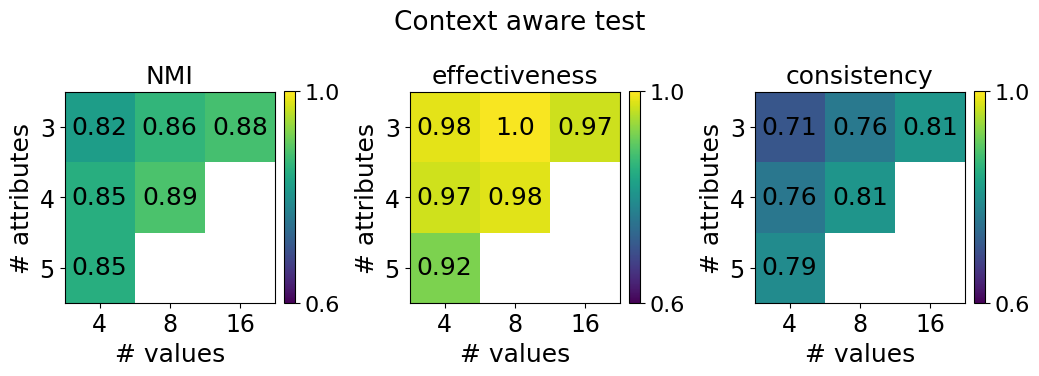

In [452]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.6, 1.0), figsize=(10.5, 3.5), 
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle='Context aware ' + test_mode)

#### Means and stds

In [11]:
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict

{'(3,4)NMI': (0.83, 0.008),
 '(3,8)NMI': (0.948, 0.005),
 '(3,16)NMI': (0.852, 0.038),
 '(4,4)NMI': (0.899, 0.007),
 '(4,8)NMI': (0.932, 0.031),
 '(5,4)NMI': (0.92, 0.011),
 '(3,4)effectiveness': (0.993, 0.005),
 '(3,8)effectiveness': (0.982, 0.024),
 '(3,16)effectiveness': (0.75, 0.058),
 '(4,4)effectiveness': (0.989, 0.021),
 '(4,8)effectiveness': (0.909, 0.064),
 '(5,4)effectiveness': (0.974, 0.013),
 '(3,4)consistency': (0.713, 0.011),
 '(3,8)consistency': (0.917, 0.021),
 '(3,16)consistency': (0.988, 0.002),
 '(4,4)consistency': (0.825, 0.007),
 '(4,8)consistency': (0.959, 0.017),
 '(5,4)consistency': (0.871, 0.02)}

### Concept-dependent

In [190]:
# from generic to specific
entropies_hierarchical = [entropy_scores['NMI_hierarchical'], entropy_scores['effectiveness_hierarchical'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[3:6]):
    results = entropies_hierarchical[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


#### Plotting Concept-level

In [191]:
data_list, run_list, level_list = [], [], []
NMI_hierarchical, effectiveness_hierarchical, consistency_hierarchical = [], [], []

for d, data in enumerate(datasets):
    for run in range(n_runs):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
                effectiveness_hierarchical.append(scores['effectiveness_hierarchical'][l])
                consistency_hierarchical.append(scores['consistency_hierarchical'][l])
            except: 
                NMI_hierarchical.append(np.nan)
                effectiveness_hierarchical.append(np.nan)
                consistency_hierarchical.append(np.nan)

entropy_dict_hierarchical = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_hierarchical, 
                             'Effectiveness': effectiveness_hierarchical, 'Consistency': consistency_hierarchical}


In [192]:
all_hierarchical = {}
len_ds = len(entropy_dict_hierarchical['Effectiveness'])
all_hierarchical['metric'] = ['Effectiveness'] * len_ds + ['Consistency'] * len_ds + ['NMI'] * len_ds
all_hierarchical['value'] = (entropy_dict_hierarchical['Effectiveness'] + 
                             entropy_dict_hierarchical['Consistency'] +
                             entropy_dict_hierarchical['NMI'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


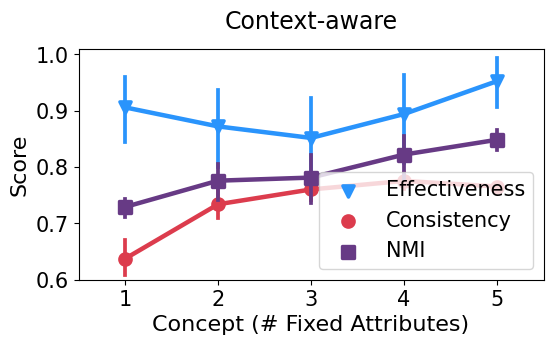

In [193]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette(['#2A94FC', '#DC3C4D', '#673A85']), scale=1.2)
plt.ylabel('Score', fontsize=16)
if context_unaware:
    plt.title('Context-unaware', fontsize=17, y=1.05)
else:
    plt.title('Context-aware', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Concept (# Fixed Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

### Context-dependent

In [453]:
# from coarse to fine context
entropies_context_dep = [entropy_scores['NMI_context_dep'], entropy_scores['effectiveness_context_dep'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[6:9]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


#### Plotting per Context condition

In [454]:
data_list, run_list, level_list = [], [], []
NMI_context_dep, effectiveness_context_dep, consistency_context_dep = [], [], []

for d, data in enumerate(datasets):
    for run in range(n_runs):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_context_dep.append(scores['normalized_mutual_info_context_dep'][l])
                effectiveness_context_dep.append(scores['effectiveness_context_dep'][l])
                consistency_context_dep.append(scores['consistency_context_dep'][l])
            except: 
                NMI_context_dep.append(np.nan)
                effectiveness_context_dep.append(np.nan)
                consistency_context_dep.append(np.nan)

entropy_dict_context_dep = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_context_dep, 
                             'Effectiveness': effectiveness_context_dep, 'Consistency': consistency_context_dep}


In [455]:
df = pd.DataFrame(entropy_dict_context_dep)
means = df.groupby(['level']).mean()
stds = df.groupby(['level']).std()
print(means['NMI'].idxmax(), round(means['NMI'].max(), 2), round(stds['NMI'][means['NMI'].idxmax()], 2))
print(means['NMI'].idxmin(), round(means['NMI'].min(), 2), round(stds['NMI'][means['NMI'].idxmin()], 2))

4 0.92 0.02
1 0.91 0.03


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_81513/2867107125.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = df.groupby(['level']).mean()
/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_81513/2867107125.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stds = df.groupby(['level']).std()


In [456]:
all_context_dep = {}
len_ds = len(entropy_dict_context_dep['Effectiveness'])
all_context_dep['metric'] = ['Effectiveness'] * len_ds + ['Consistency'] * len_ds +['NMI'] * len_ds 
all_context_dep['value'] = (entropy_dict_context_dep['Effectiveness'] + 
                             entropy_dict_context_dep['Consistency'] +
                             entropy_dict_context_dep['NMI']
                            )
all_context_dep['level'] = entropy_dict_context_dep['level'] * 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


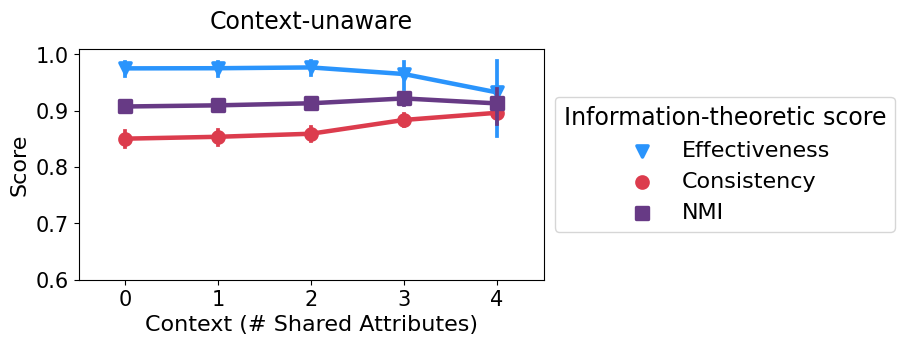

In [457]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette(['#2A94FC', '#DC3C4D', '#673A85']), 
                   scale=1.2)
plt.ylabel('Score', fontsize=16)
if context_unaware:
    plt.title('Context-unaware', fontsize=17, y=1.05)
else:
    plt.title('Context-aware', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Context (# Shared Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='Information-theoretic score', title_fontsize=17)
plt.show()

### Concept x Context

In [20]:
# from generic&coarse to specific&fine
entropies_concept_x_context = [entropy_scores['NMI_concept_x_context'], entropy_scores['effectiveness_concept_x_context'], entropy_scores['consistency_concept_x_context']]
entropy_dict_conc_x_cont = {}
for i, score in enumerate(list(entropy_scores.keys())[9:]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_conc_x_cont[d + score] = mean[idx] #(mean[idx], sd[idx])

#### NMI

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/plot_helpers.py:141: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


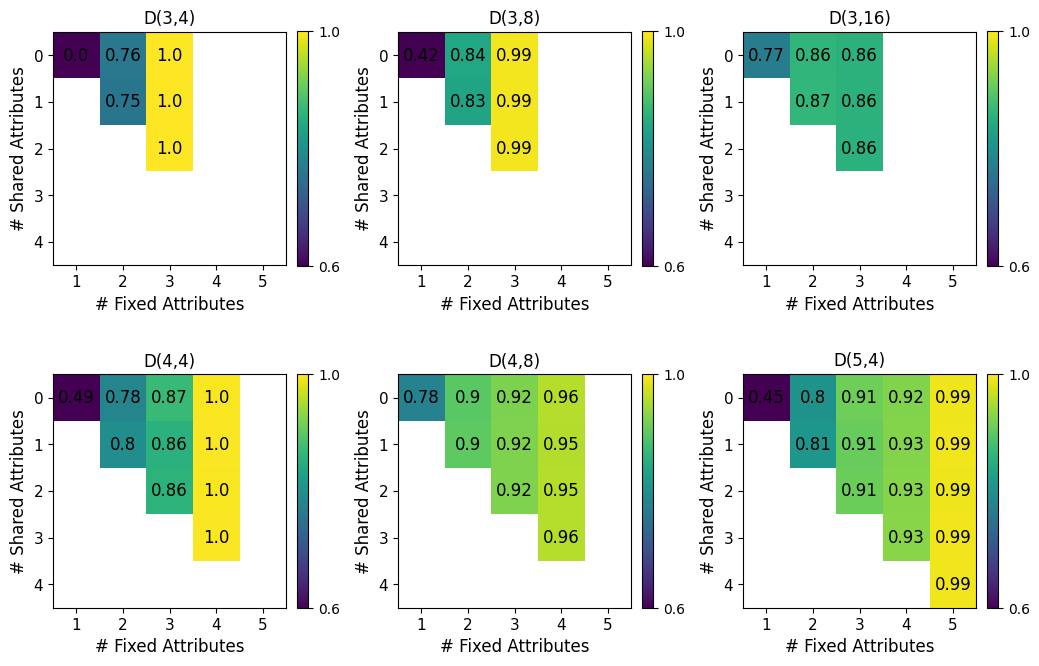

In [21]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='NMI', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

#### effectiveness

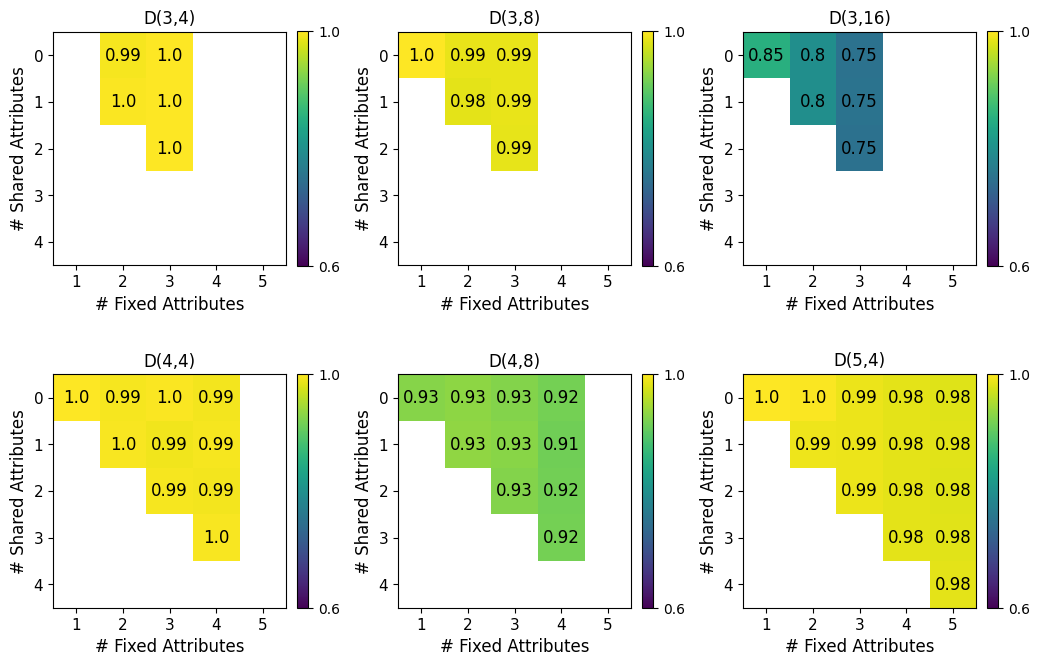

In [22]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='effectiveness', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

#### consistency

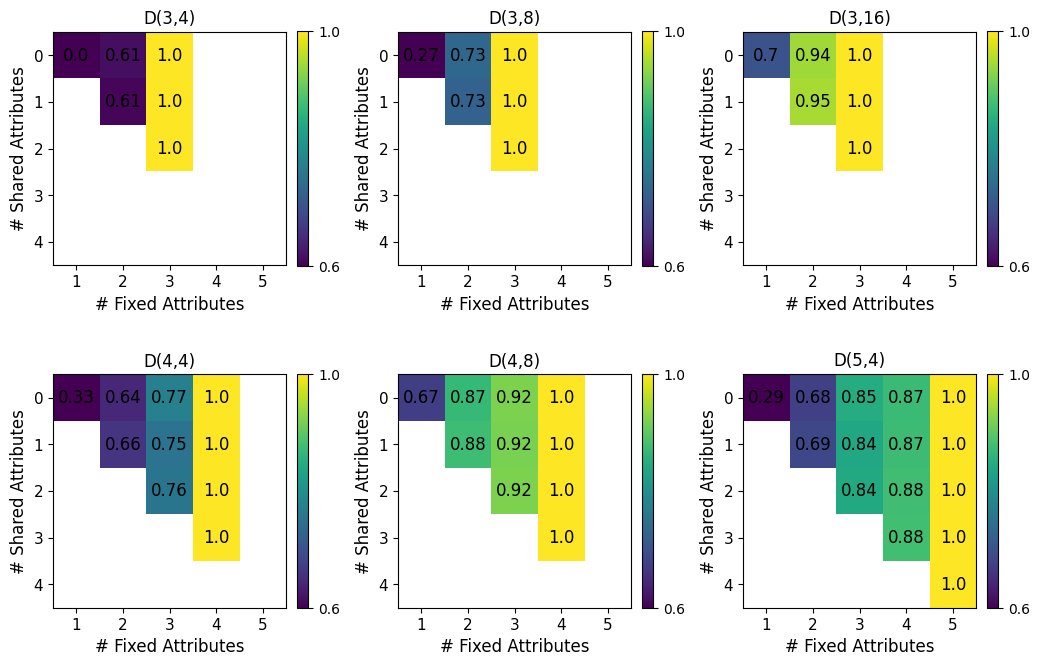

In [23]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='consistency', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

## Symbol redundancy

In [79]:
symbol_redundancy_dict = {'level': [], 'data set': [], 'run': [], 'symbol frequency': []}

for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/symbol_redundancy.pkl', 'rb'))
            
        for level in range(5):
            
            symbol_redundancy_dict['level'].append(level)
            symbol_redundancy_dict['run'].append(run)
            symbol_redundancy_dict['data set'].append(dataset)
            try: 
                symbol_redundancy_dict['symbol frequency'].append(scores['symbol_redundancy'][level])
            except: 
                symbol_redundancy_dict['symbol frequency'].append(np.NaN)

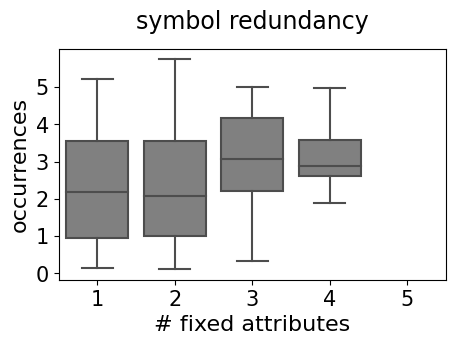

In [80]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='symbol frequency', data=symbol_redundancy_dict, color='gray')
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5], fontsize=15)
plt.yticks(ticks=[0, 1, 2, 3, 4, 5], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('occurrences', fontsize=16)
plt.title('symbol redundancy', fontsize=17, y=1.05)
plt.show()

## Compositionality

In [43]:
topsim, posdis, bosdis = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_specific, posdis_specific, bosdis_specific = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_generic, posdis_generic, bosdis_generic = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))

for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        
        topsim_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        topsim[d, run] = topsim_score['topsim_train']
        posdis[d, run] = disent_score['posdis']
        bosdis[d, run] = disent_score['bosdis']
        topsim_specific[d, run] = topsim_score['topsim_specific_train']
        posdis_specific[d, run] = disent_score['posdis_specific']
        bosdis_specific[d, run] = disent_score['bosdis_specific']
        topsim_generic[d, run] = topsim_score['topsim_generic_train']
        posdis_generic[d, run] = disent_score['posdis_generic']
        bosdis_generic[d, run] = disent_score['bosdis_generic']

FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,4)_game_size_10_vsf_0/context_unaware/sampled_context/0/posdis_bosdis.pkl'

### Topsim

In [42]:
for i, d in enumerate(datasets):
    print(d, "topsim:", round(np.mean(topsim[i]), 3), "sd", round(np.std(topsim[i]), 2))

(3,4) topsim: 0.46 sd 0.07
(3,8) topsim: 0.411 sd 0.06
(3,16) topsim: 0.287 sd 0.04
(4,4) topsim: 0.418 sd 0.04
(4,8) topsim: 0.336 sd 0.05
(5,4) topsim: 0.431 sd 0.06


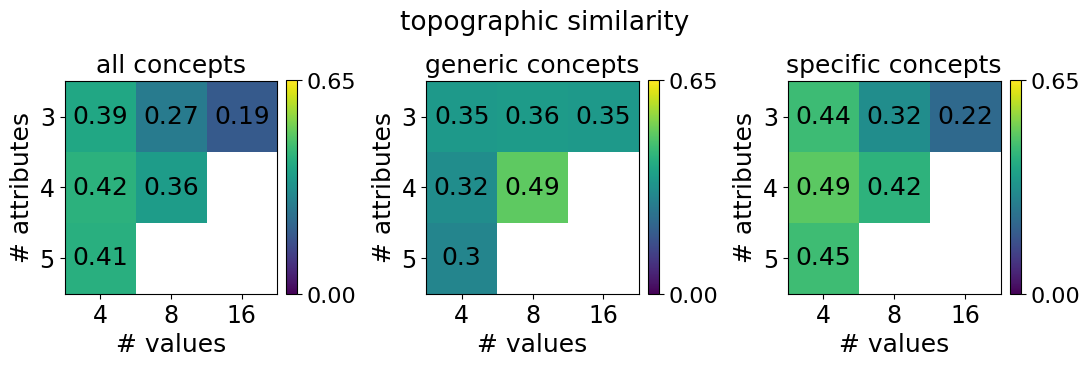

In [43]:
plot_heatmap([topsim, topsim_generic, topsim_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5), 
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='topographic similarity', suptitle_position=1.)

#### Topographic similarity over time

In [12]:
topsim_over_time = {}

for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/topsim_over_time.pkl', 'rb'))
            
        topsim_over_time[d][run] = scores
            
plt.plot(topsim_over_time[0][0])
round(max(topsim_over_time[0][0]) - min(topsim_over_time[0][0]), 3)

FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,4)_game_size_10_vsf_3/standard/0/topsim_over_time.pkl'

### Posdis

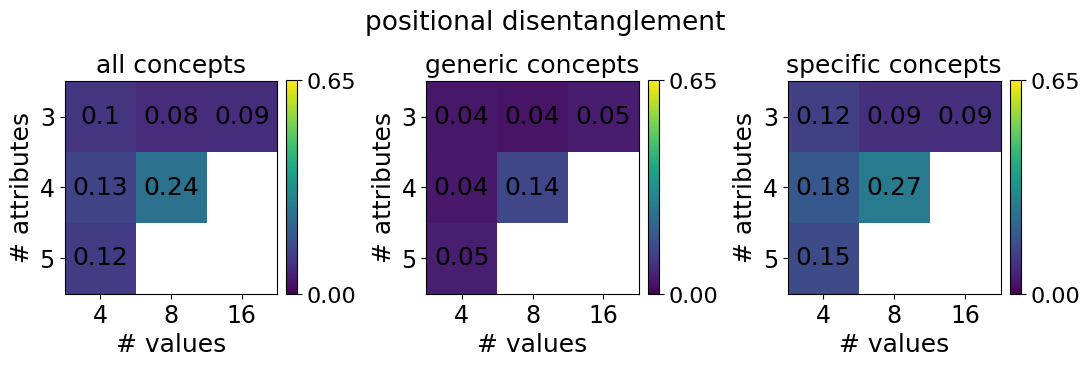

In [44]:
plot_heatmap([posdis, posdis_generic, posdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='positional disentanglement', suptitle_position=1.)

In [52]:
posdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(n_runs):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_scores.pkl', 'rb')))
    posdis.append(sublist)

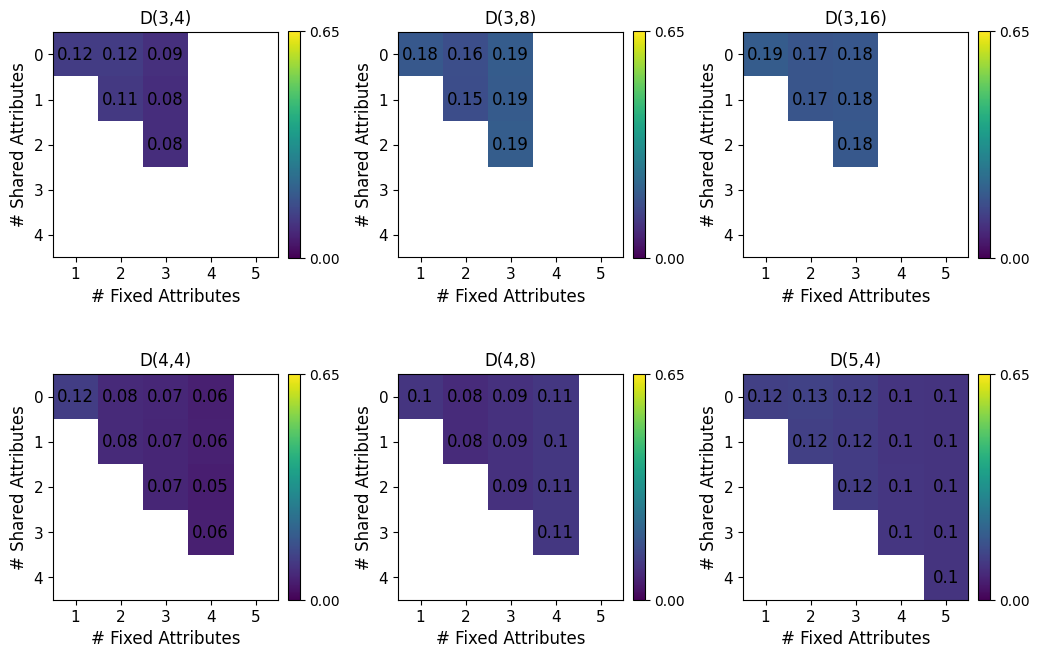

In [53]:
plot_heatmap_concept_x_context(posdis, score='posdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Bosdis

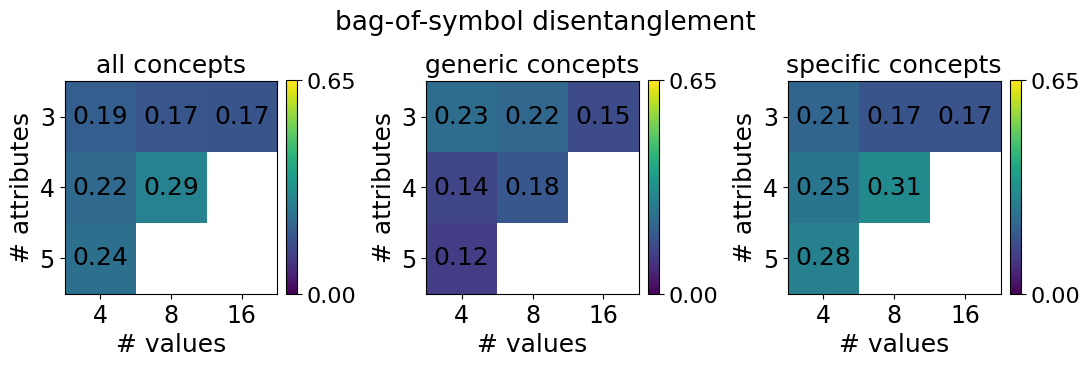

In [48]:
plot_heatmap([bosdis, bosdis_generic, bosdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='bag-of-symbol disentanglement', suptitle_position=1.)

In [49]:
bosdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(n_runs):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/bosdis_scores.pkl', 'rb')))
    bosdis.append(sublist)

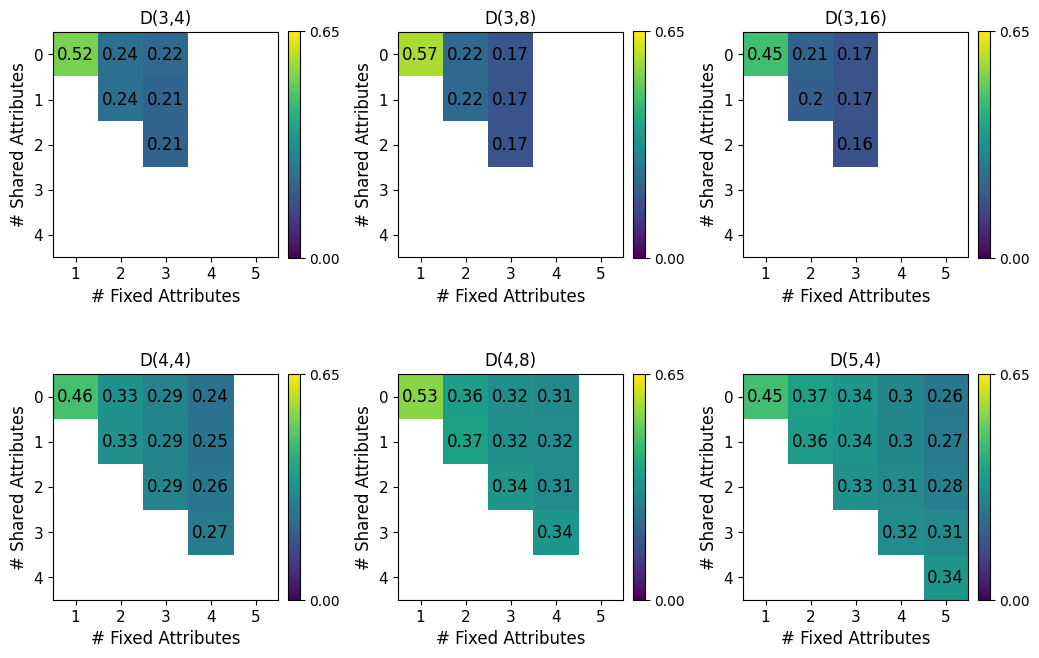

In [50]:
plot_heatmap_concept_x_context(bosdis, score='bosdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Compositionality per dataset

In [35]:
# compositionality scores for each data set

compositionality_scores = {'dataset':[], 'run':[], 'metric':[], 'data':[], 'score':[]}

for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        
        topsim = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
            #for data in ['all', 'concrete']: 
            for data in ['all']:
                
                compositionality_scores['dataset'].append(dataset)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)
                compositionality_scores['data'].append(data)
                
                append = '' if data == 'all' else '_max_relevance'
                    
                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim' + append + '_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis' + append])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis' + append])

compositionality_scores = pd.DataFrame(compositionality_scores)

In [199]:
sns.boxplot(x='metric', y='score', data=compositionality_scores[compositionality_scores.data=='all'], 
            hue='dataset', palette='deep')
plt.xlabel(xlabel='metric', fontsize=17)
plt.ylabel(ylabel='score', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=16)
plt.ylim(0, 0.65)
legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
plt.setp(legend.get_title(),fontsize='x-large')
plt.title('compositionality scores', fontsize=18)
plt.show()

NameError: name 'compositionality_scores' is not defined

## Errors

In [200]:
validation = True # set to false if training interaction should be used
setting = 'standard'

In [57]:
import torch
from utils.analysis_from_interaction import *

In [201]:
def error_analysis(datasets, paths, setting, n_epochs, n_values, validation=True):
    """
    goes through interactions, retrieves concept and context conditions and counts errors, 
    i.e. incorrectly classified objects (by the receiver)
    """
    all_error_concepts = {}
    all_error_contexts = {}
    all_error_concept_x_context = {}
    all_false_positives = {}
    all_false_negatives = {}
    all_total_errs = {}

    all_acc_concept_x_context = {}

    all_total_concepts = {}
    all_total_contexts = {}
    all_total_concept_x_context = {}

    # go through all datasets
    for i, d in enumerate(datasets):
        print(i, d)
        error_concepts = {}
        error_contexts = {}
        error_concept_x_context = {}
        false_positives = {}
        false_negatives = {}
        total_errs = {}
        acc_concept_x_context = {}
        # select first run
        path_to_run = paths[i] + '/' + str(setting) + '/' + str(0) + '/'
        path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
        path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0')
        if validation:
            interaction = torch.load(path_to_interaction_val)
        else:
            interaction = torch.load(path_to_interaction_train)

        total_concepts = obtain_concept_counts(interaction.sender_input, n_values[i])

        total_contexts = obtain_context_counts(interaction.sender_input, n_values[i])

        total_concept_x_context = obtain_concept_x_context_counts(interaction.sender_input, n_values[i])

        for j in range(len(interaction.sender_input)):
            receiver_pred = (interaction.receiver_output[j][-1] > 0).float()  # use last symbol of message

            (objects, fixed) = get_fixed_vectors(interaction.sender_input, n_values[i], j)
            concept_str = str(int(sum(fixed[0])))

            context_conds = get_context_cond(interaction.sender_input, n_values[i], j, objects, fixed)
            context_str = str(context_conds[0])
            concept_x_context_str = (context_conds[0], int(sum(fixed[0]) - 1))
            
            # check if receiver has classified all objects correctly as targets or distractors
            if not torch.equal(receiver_pred, interaction.labels[j]):
                if concept_str in error_concepts:
                    error_concepts[concept_str] += 1
                else:
                    error_concepts[concept_str] = 1

                if context_str in error_contexts:
                    error_contexts[context_str] += 1
                else:
                    error_contexts[context_str] = 1

                if concept_x_context_str in error_concept_x_context:
                    error_concept_x_context[concept_x_context_str] += 1
                else:
                    error_concept_x_context[concept_x_context_str] = 1
                    
                # calculate false positives and false negatives
                num_false_pos = 0
                num_false_neg = 0
                errors = receiver_pred - interaction.labels[j]
                for error in errors:
                    # false positives
                    if error > 0:
                        num_false_pos += 1
                    # false negatives
                    elif error < 0:
                        num_false_neg += 1
                if concept_x_context_str in false_positives:
                    false_positives[concept_x_context_str] += num_false_pos
                else:
                    false_positives[concept_x_context_str] = num_false_pos
                if concept_x_context_str in false_negatives:
                    false_negatives[concept_x_context_str] += num_false_neg
                else:
                    false_negatives[concept_x_context_str] = num_false_neg
                if concept_x_context_str in total_errs:
                    total_errs[concept_x_context_str] += (num_false_pos + num_false_neg)
                else:
                    total_errs[concept_x_context_str] = (num_false_pos + num_false_neg)
                #print("per round", error_concept_x_context)
                #print("total", total_errs)

            # check if receiver has classified some objects correctly as targets or distractors
            # (this is how the accuracy is calculated during training)
            if concept_x_context_str in acc_concept_x_context:
                acc_concept_x_context[concept_x_context_str] += (
                    (receiver_pred == interaction.labels[j]).float().mean().numpy())
            else:
                acc_concept_x_context[concept_x_context_str] = (
                        receiver_pred == interaction.labels[j]).float().mean().numpy()
                
        #print(error_concept_x_context)
        #print("total errs", total_errs)
        #print("total cxc", total_concept_x_context)

        all_error_concepts[d] = error_concepts
        all_error_contexts[d] = error_contexts
        all_error_concept_x_context[d] = error_concept_x_context
        all_false_positives[d] = false_positives
        all_false_negatives[d] = false_negatives
        all_total_errs[d] = total_errs

        all_acc_concept_x_context[d] = acc_concept_x_context

        all_total_concepts[d] = total_concepts
        all_total_contexts[d] = total_contexts
        all_total_concept_x_context[d] = total_concept_x_context

    return (all_error_concepts, all_error_contexts, all_error_concept_x_context, 
            all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
            all_total_concepts, all_total_contexts, all_total_concept_x_context)

In [202]:
(all_error_concepts, all_error_contexts, all_error_concept_x_context, 
 all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
 all_total_concepts, all_total_contexts, all_total_concept_x_context) = error_analysis(datasets, paths, setting, n_epochs, n_values, validation)

0 (3,4)
1 (3,8)
2 (3,16)
3 (4,4)
4 (4,8)
5 (5,4)


In [101]:
err_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_error_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_error_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    err_ratio_concept_x_context[d] = ratio_concept_x_context

In [158]:
all_total_errs['(3,4)'] # how many objects were classified incorrectly per condition

{(2, 2): 92, (0, 1): 17, (1, 1): 60}

In [164]:
all_error_concept_x_context['(3,4)'] # how often data in a specific condition was classified incorrectly

{(2, 2): 34, (0, 1): 4, (1, 1): 16}

In [159]:
all_total_concept_x_context['(3,4)'] # how often the specific concept x context condition is present in the interaction

{(0, 2): 118, (2, 2): 144, (1, 2): 121, (1, 1): 101, (0, 1): 91, (0, 0): 21}

In [149]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    print(d)
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        print(concept_x_context)
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / #* (all_total_errs[d][concept_x_context] / 
            all_total_concept_x_context[d][concept_x_context], 4)
            #print(all_false_positives[d][concept_x_context] / all_total_errs[d][concept_x_context])
            print(all_total_errs[d][concept_x_context], all_total_concept_x_context[d][concept_x_context], all_total_errs[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
            print(all_false_positives[d][concept_x_context], all_false_positives[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

(3,4)
(0, 2)
(2, 2)
92 144 0.6388888888888888
92 0.6388888888888888
(1, 2)
(1, 1)
60 101 0.594059405940594
23 0.22772277227722773
(0, 1)
17 91 0.18681318681318682
0 0.0
(0, 0)
(3,8)
(1, 1)
190 402 0.472636815920398
40 0.09950248756218906
(0, 2)
1 1022 0.0009784735812133072
1 0.0009784735812133072
(2, 2)
370 1025 0.36097560975609755
370 0.36097560975609755
(1, 2)
12 986 0.012170385395537525
12 0.012170385395537525
(0, 1)
117 399 0.2932330827067669
0 0.0
(0, 0)
26 44 0.5909090909090909
0 0.0
(3,16)
(1, 2)
303 8253 0.036713922210105415
133 0.016115351993214587
(2, 2)
4144 8132 0.5095917363502214
3954 0.48622725036891296
(0, 1)
739 1562 0.4731113956466069
10 0.006402048655569782
(0, 2)
134 8168 0.016405484818805095
4 0.0004897159647404506
(1, 1)
1150 1561 0.7367072389493914
456 0.29212043561819345
(0, 0)
226 92 2.4565217391304346
11 0.11956521739130435
(4,4)
(1, 3)
(1, 2)
71 495 0.14343434343434344
0 0.0
(3, 3)
283 526 0.5380228136882129
283 0.5380228136882129
(1, 1)
56 188 0.2978723404255

In [203]:
false_objects_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_total_errs[d]:
            ratio_concept_x_context[concept_x_context] = round(all_total_errs[d][concept_x_context] / (all_total_concept_x_context[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_objects_ratio[d] = ratio_concept_x_context

In [194]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

In [195]:
false_negatives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_negatives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_negatives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_negatives_ratio[d] = ratio_concept_x_context

In [94]:
acc_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_acc_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_acc_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    acc_ratio_concept_x_context[d] = ratio_concept_x_context

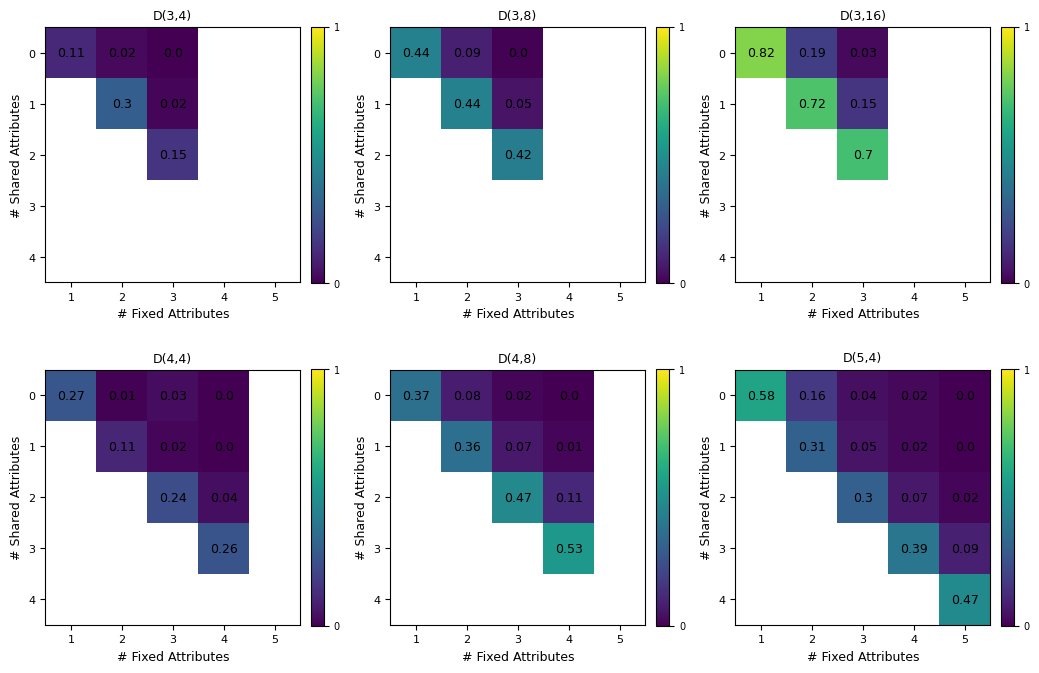

In [104]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

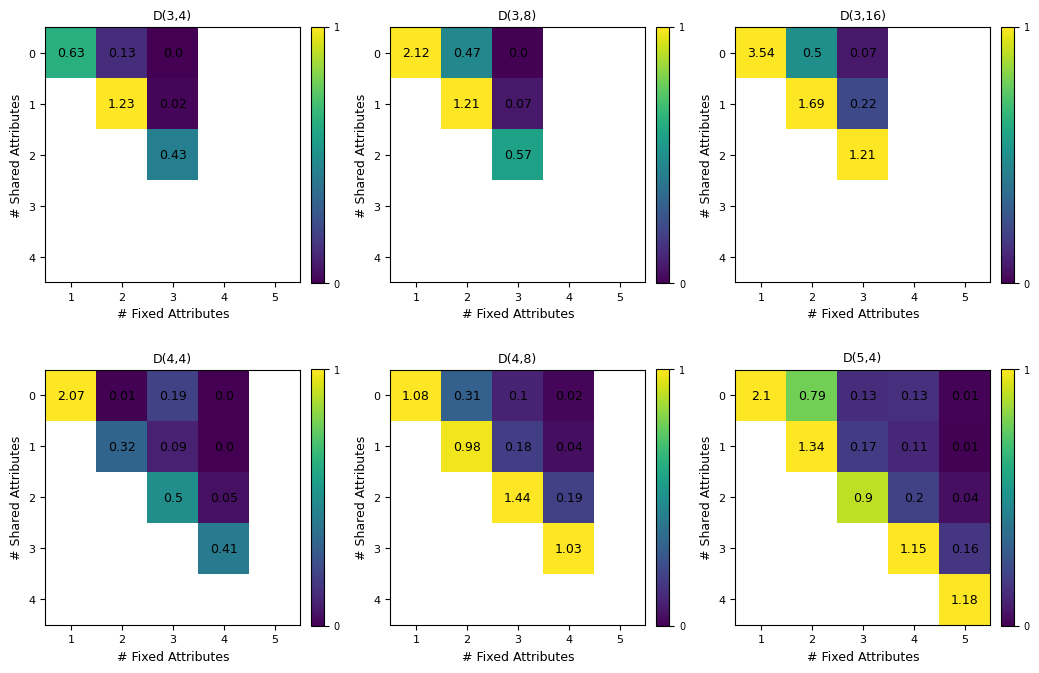

In [204]:
plot_heatmap_concept_x_context_errors(false_objects_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

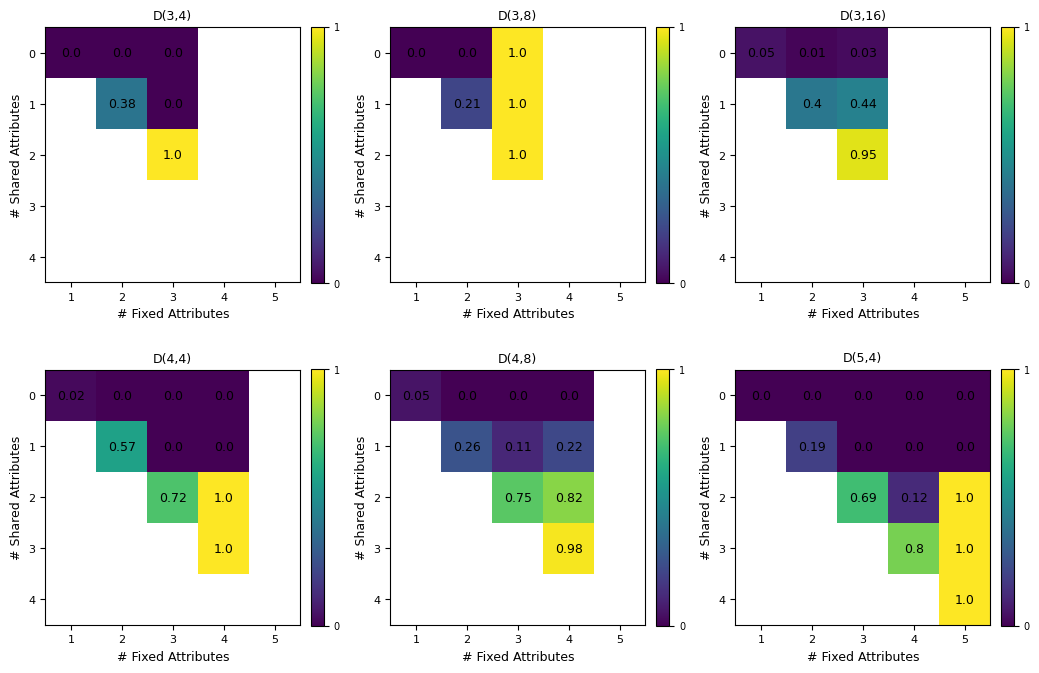

In [196]:
plot_heatmap_concept_x_context_errors(false_positives_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

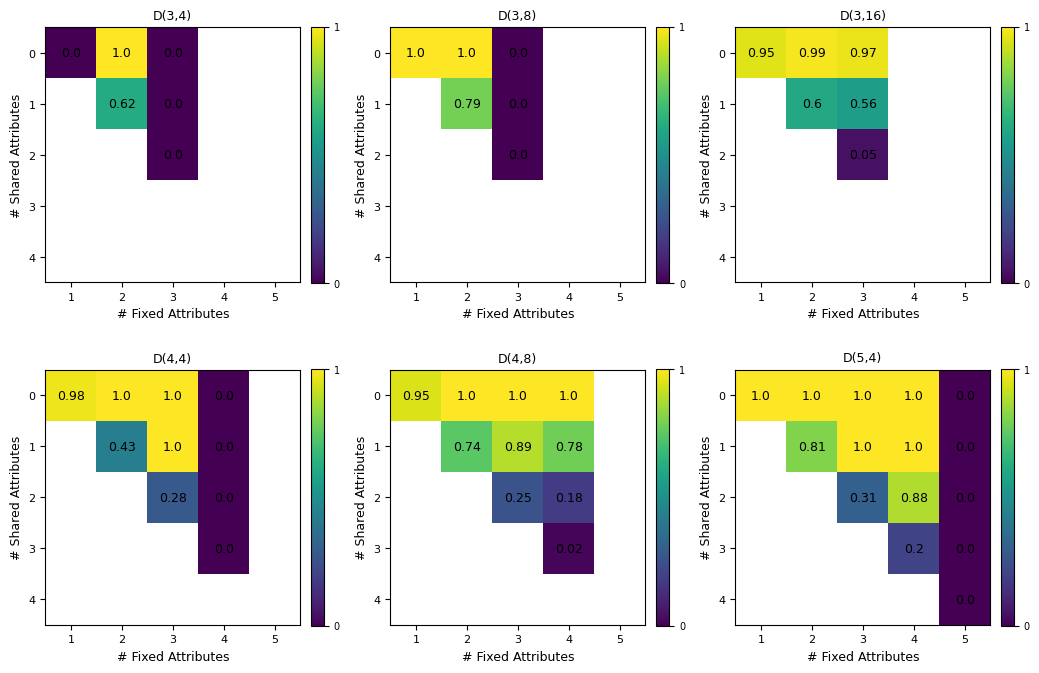

In [197]:
plot_heatmap_concept_x_context_errors(false_negatives_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

In [210]:
import numpy as np
from collections import Counter

# Gegebene Liste von Objekten
# objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0), (2, 1, 1), (0, 1, 0), (2, 0, 0)] # 1.79
objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0)] # 2.58
objects = [(2, 1, 0,), (2, 0, 1), (2, 2, 2), (1, 1, 1), (0, 1, 0), (1, 0, 0)] # 2.58

# 1. Bestimme die Häufigkeit jedes einzigartigen Objekts in der Liste
object_counts = Counter(objects)

# 2. Berechne die relative Häufigkeit jedes Objekts
total_objects = len(objects)
object_probabilities = {obj: count / total_objects for obj, count in object_counts.items()}

# 3. Verwende die Formel für die Entropie, um die Entropie zu berechnen
entropy = -sum(prob * np.log2(prob) for prob in object_probabilities.values())

# Ausgabe der berechneten Entropie
print("Die berechnete Entropie beträgt:", entropy)

Die berechnete Entropie beträgt: 2.584962500721156


In [206]:
import numpy as np
from collections import Counter

# Gegebene Liste von Objekten
objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0), (2, 1, 1), (0, 1, 0), (2, 0, 0)]

# Transpose the list of objects to get attributes as columns
attributes = np.array(objects).T

# Initialize a list to store the entropy for each attribute
attribute_entropy = []

# Calculate entropy for each attribute
for attribute_values in attributes:
    # 1. Bestimme die Häufigkeit jedes einzigartigen Werts in der Liste
    attribute_counts = Counter(attribute_values)
    
    # 2. Berechne die relative Häufigkeit jedes Werts
    total_values = len(attribute_values)
    value_probabilities = {value: count / total_values for value, count in attribute_counts.items()}
    
    # 3. Verwende die Formel für die Entropie, um die Entropie zu berechnen
    entropy = -sum(prob * np.log2(prob) for prob in value_probabilities.values() if prob != 0)
    
    attribute_entropy.append(entropy)

# Ausgabe der berechneten Entropie für jedes Attribut
print("Die berechnete Entropie für jedes Attribut beträgt:", attribute_entropy)

Die berechnete Entropie für jedes Attribut beträgt: [0.6500224216483541, 0.6500224216483541, 0.6500224216483541]


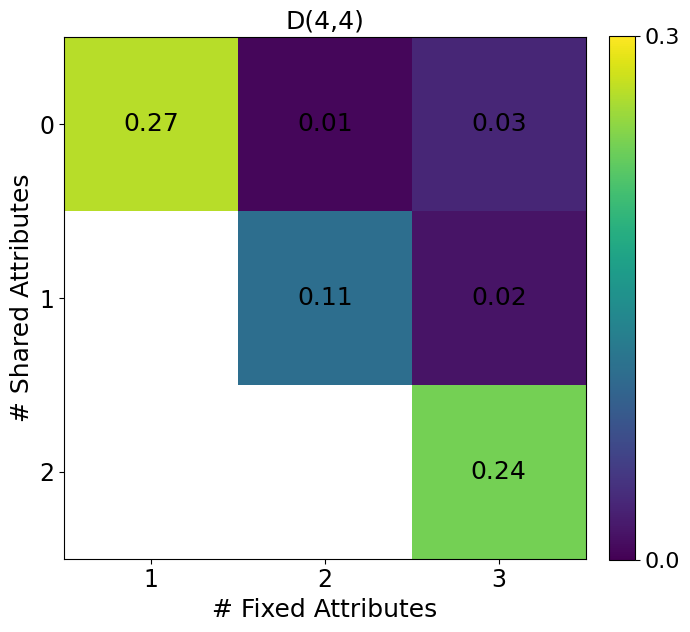

In [211]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context['(4,4)'], one_dataset=True, attributes=4, titles=('D(4,4)',), ylims=(0, 0.3), plot_dims=(1, 1))